In [48]:
import torch
import requests
import config
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import data_handling, helpers
import random


def visualize_nans(df):
	# heatmap to visualize the distribution of NaN values after removing some

	plt.figure(figsize=(16, 4))
	sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
	plt.xlabel('Time Points')
	plt.ylabel('Time Series')
	plt.title('Distribution of NaN Values in Time Series Data')
	plt.show()


"""
Name, unique series, length, mean/std for test/val after cleaning;
ETL, 348, 8761; 	val: (mean: 0.3418, std: 1.1824), test: (mean: 0.0924, std: 1.0636)
Bavaria, 59, 14142; val: (mean: 1.9037, std: 0.3079), test: (mean: 2.5892, std: 0.6260)
Genome, 1455,14621; val: (mean: 0.0144, std: 1.0923), test: (mean: 40.24, std: 17527.9)
"""

'\nName, unique series, length, mean/std for test/val after cleaning;\nETL, 348, 8761; \tval: (mean: 0.3418, std: 1.1824), test: (mean: 0.0924, std: 1.0636)\nBavaria, 59, 14142; val: (mean: 1.9037, std: 0.3079), test: (mean: 2.5892, std: 0.6260)\nGenome, 1455,14621; val: (mean: 0.0144, std: 1.0923), test: (mean: 40.24, std: 17527.9)\n'

In [40]:
import pandas as pd
df = pd.read_csv("/vol/fob-vol7/nebenf21/reinbene/bene/MA/data/dataset_metrics.csv", index_col=0)
df = df.transpose()
df.loc["num. series"] = df.loc["num. series"].astype("int")
df.loc[["num. series", "timesteps", "mean validation", "mean test", "std. val", "std. test"]]


Name,ETL,Bavaria,Genome
num. series,348.0000,59.0000,1455.0000
timesteps,8761.0000,14142.0000,14621.0000
mean validation,0.3418,1.9037,0.0144
mean test,0.0924,2.5892,40.2400
std. val,1.1824,0.3079,1.0923
std. test,1.0636,0.6260,17527.9000


# europre grid elecrticity

europe electricity data
jupyterNB for explanation: https://nbviewer.org/github/Open-Power-System-Data/datapackage_timeseries/blob/2020-10-06/main.ipynb
- 50k entries
- 300 variates
- countries have different variates as some dont have wind/offshore or some NANs

In [90]:
data_dict = data_handling.load_electricity()
length = len(data_dict["train"]) + len(data_dict["validation"]) + len(data_dict["test"])
ELD_metrics = pd.Series([length, 
                        data_dict["train"].size(1),
                        data_dict["validation"].mean().item(),
                        data_dict["test"].mean().item(),
                        data_dict["validation"].std().item(),
                        data_dict["test"].std().item()])



data_tensor = data_handling.load_bavaria_electricity()
length = data_tensor.size(0)
ids = data_tensor.size(1)
data_dict, standadizer = data_handling.train_test_split_eu_elec(data_tensor, standardize=True)

Bavaria_metrics = pd.Series([length,
                             ids,
                            data_dict["validation"].mean().item(),
                            data_dict["test"].mean().item(),
                            data_dict["validation"].std().item(),
                            data_dict["test"].std().item()])


data_tensor = data_handling.load_genome_project_data()
length = data_tensor.size(0)
ids = data_tensor.size(1)
data_dict, standadizer = data_handling.train_test_split_eu_elec(data_tensor, standardize=True)

GP2_metrics = pd.Series([length,
                         ids,
                         data_dict["validation"].mean().item(),
                         data_dict["test"].mean().item(),
                         data_dict["validation"].std().item(),
                         data_dict["test"].std().item()])

column_names = ["timesteps", "num. series", "mean validation", "mean test", "std. val", "std. test"]

dataset_metrics = pd.DataFrame([ELD_metrics, Bavaria_metrics, GP2_metrics])
dataset_metrics.columns=column_names
dataset_metrics = dataset_metrics.transpose()
dataset_metrics.columns=["ELD", "Bavaria", "GP2"]
dataset_metrics

,ELD,Bavaria,GP2
timesteps,8761.000000,14142.000000,14621.000000
num. series,348.000000,59.000000,1454.000000
mean validation,0.341808,1.903690,0.014425
mean test,0.092414,2.589244,-0.085100
std. val,1.182404,0.307885,1.092719
std. test,1.063594,0.625968,1.177494


/home/ben_ten/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


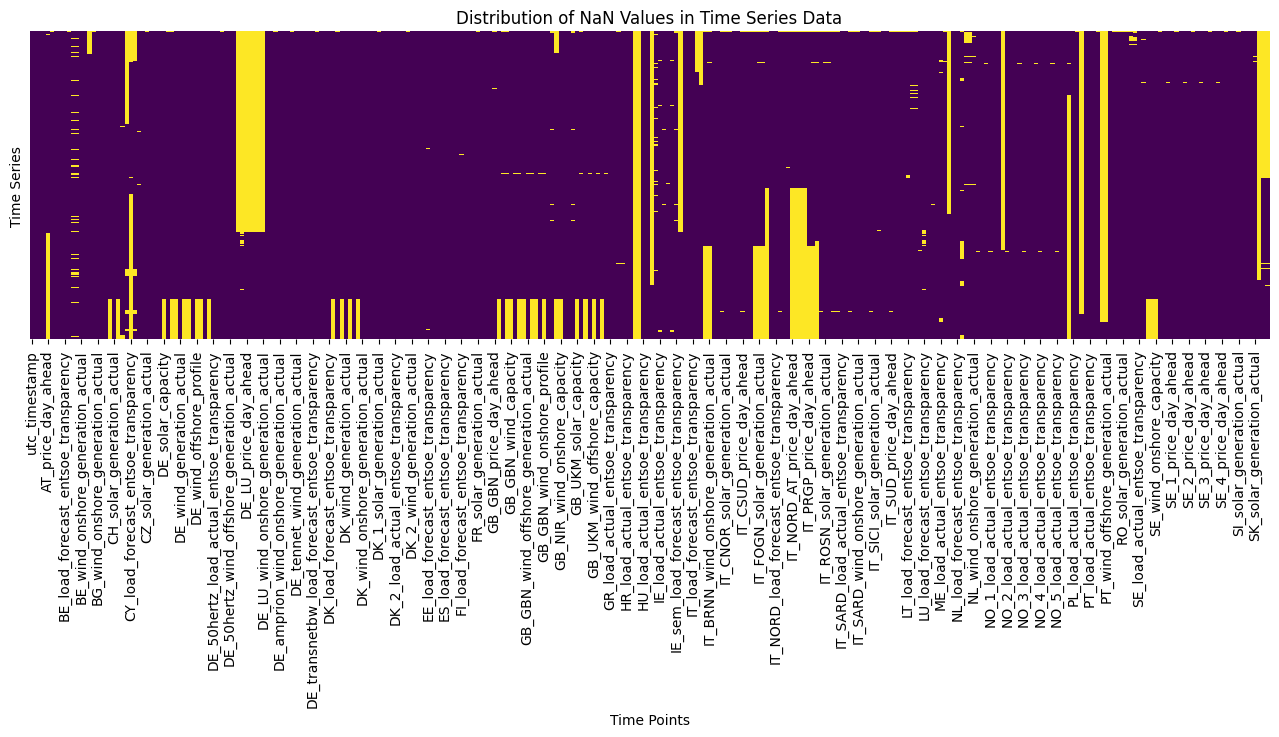

In [1]:
df = pd.read_csv(config.CONFIG_DATA["eu_electricity"] / ".csv")
print(df.head())
visualize_nans(df)

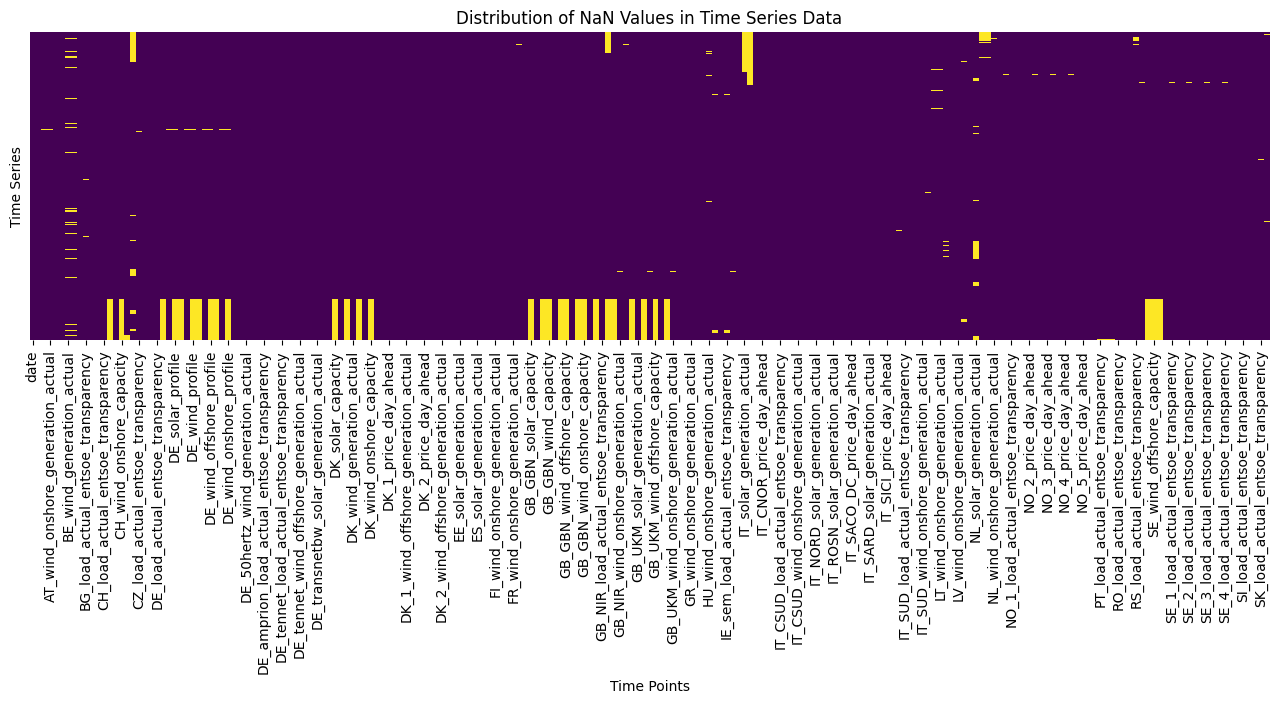

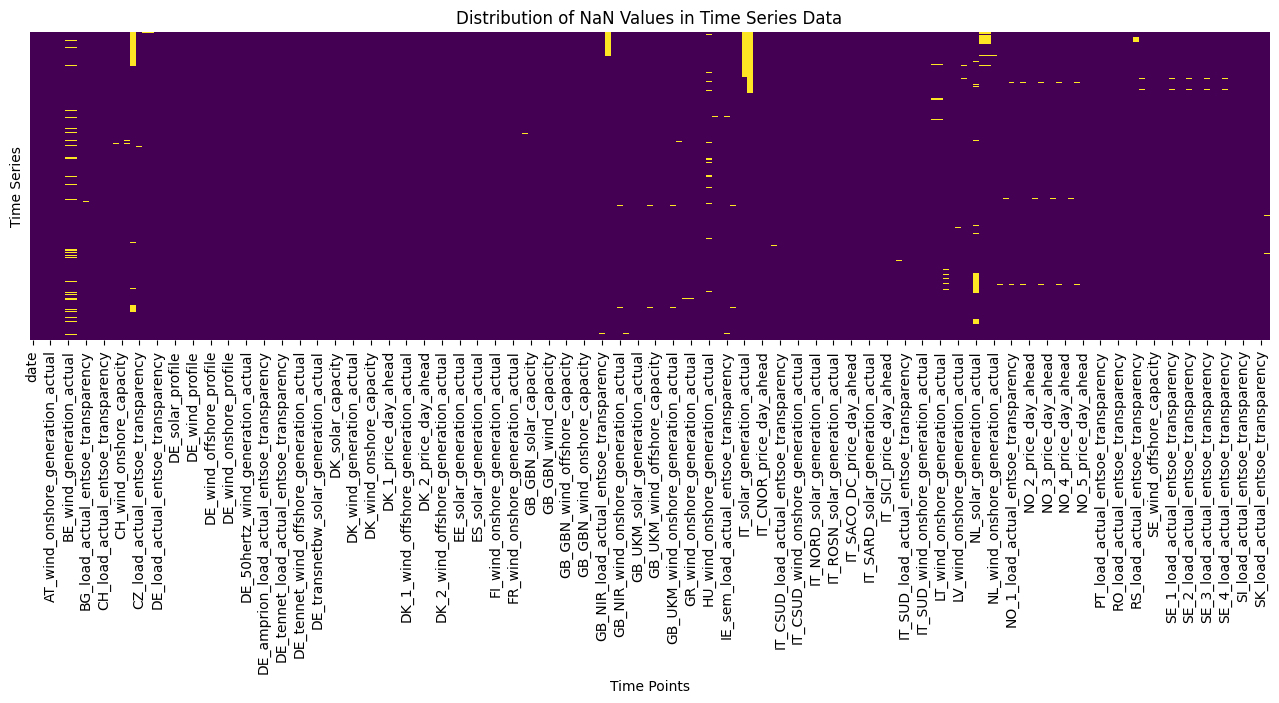

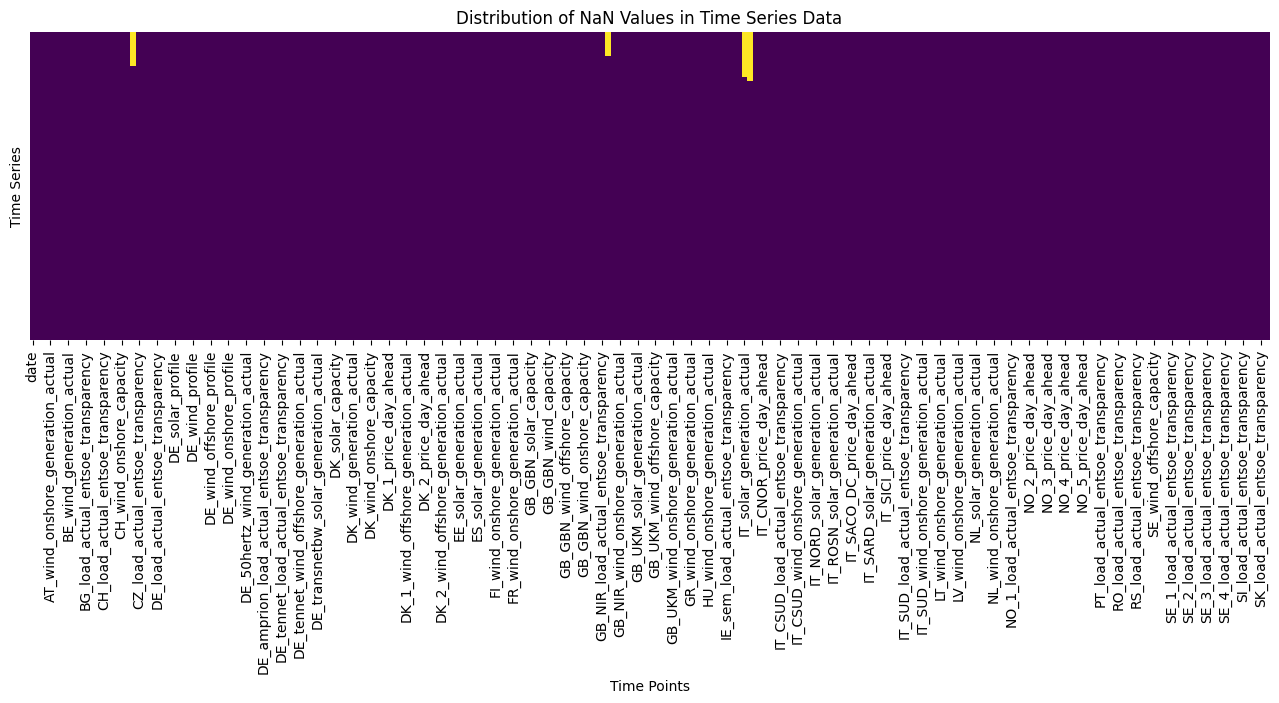

In [3]:
# drop second timestamp column
df = df.drop('cet_cest_timestamp', axis=1)

# rename to fit DataSetClass
df.rename(columns={'utc_timestamp': 'date'}, inplace=True)


# drop forecast because its synthetic data
columns_to_delete = ['forecast']
df = df.drop([col for col in df.columns if any(partial_name in col for partial_name in columns_to_delete)], axis=1)

# drop columns with more than 40% missing values
threshold = 0.3 * len(df)
columns_to_drop = df.columns[df.isna().sum() > threshold]
df = df.drop(columns=columns_to_drop)
visualize_nans(df)

# drop rows with more than 5% NANs from start and end
counter_start = 0
while df.iloc[0].isnull().mean() > 0.05:
    df.drop(df.index[0], inplace=True)
    counter_start +=1
print("start rows removed: ", counter_start)

counter_end = 0
while df.iloc[-1].isnull().mean() > 0.05:
    df.drop(df.index[-1], inplace=True)
    counter_end += 1
print("end rows removed: ", counter_end)
visualize_nans(df)

# forward fill if previous values are present
df = df.fillna(method='ffill')
visualize_nans(df)

# values at the start are set to zero, no more NANs
df = df.fillna(0)

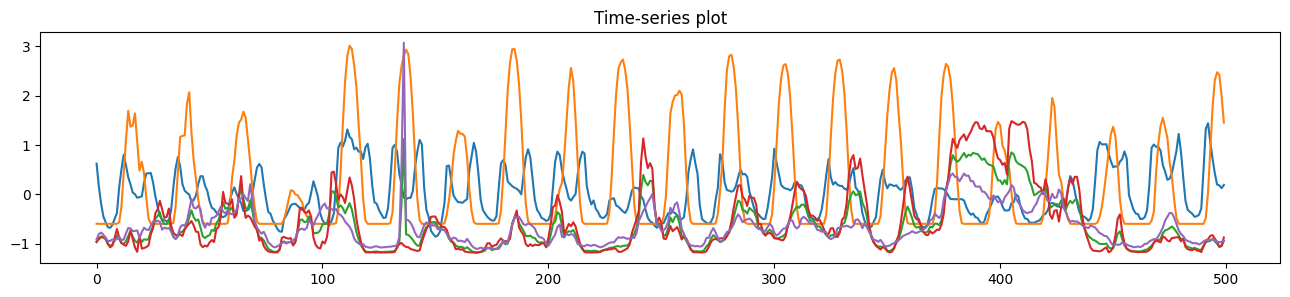

In [1]:
# sanity check if conversion worked correctly
# select 5 random time-series and 500 datapoints each
data_tensor = data_handling.eu_electricity_to_tensor()
data_dict, standardize_values =  data_handling.train_test_split_eu_elec(data_tensor, standardize=True)
train_tensor = data_dict["train"]

time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)

numpy_array = train_tensor[time_id : time_id+500 , ids : ids+5].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

# electricity ECL

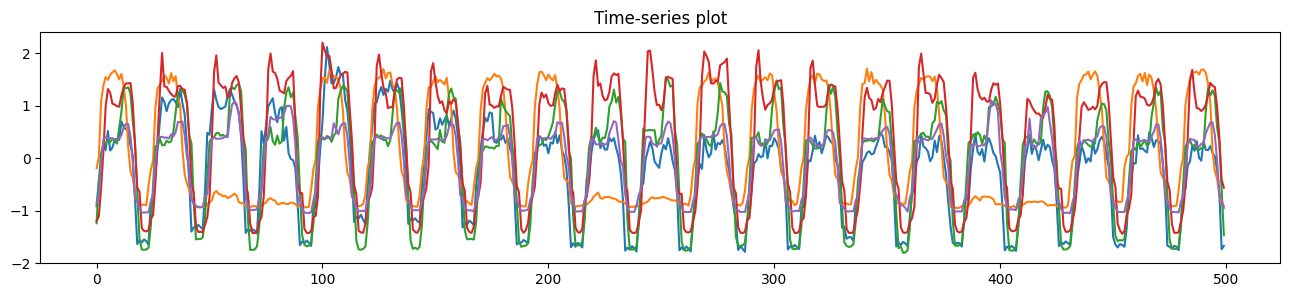

In [3]:
# sanity check if conversion worked correctly
# select 5 random time-series and 500 datapoints each
electricity_dict = data_handling.load_electricity()
train_tensor = electricity_dict["electricity_train"]

time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)

numpy_array = train_tensor[time_id : time_id+500 , ids : ids+5].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

# electricity load southern germany

https://data.open-power-system-data.org/household_data/

In [2]:
url = "https://data.open-power-system-data.org/household_data/2020-04-15/household_data_60min_singleindex.csv"



# URL of the CSV dataset

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the content of the response as a CSV file using pandas
    df = pd.read_csv(url)
    
    # Now you can work with the DataFrame (df) containing your CSV data
    print("Download succesfull.")  # Display the first few rows of the DataFrame
else:
    print("Failed to download the dataset. Status code:", response.status_code)

df.to_csv(config.CONFIG_DATA["south_germany"] / 'south_germany.csv', index=False)
print("File saved.")


Download succesfull.
File saved.


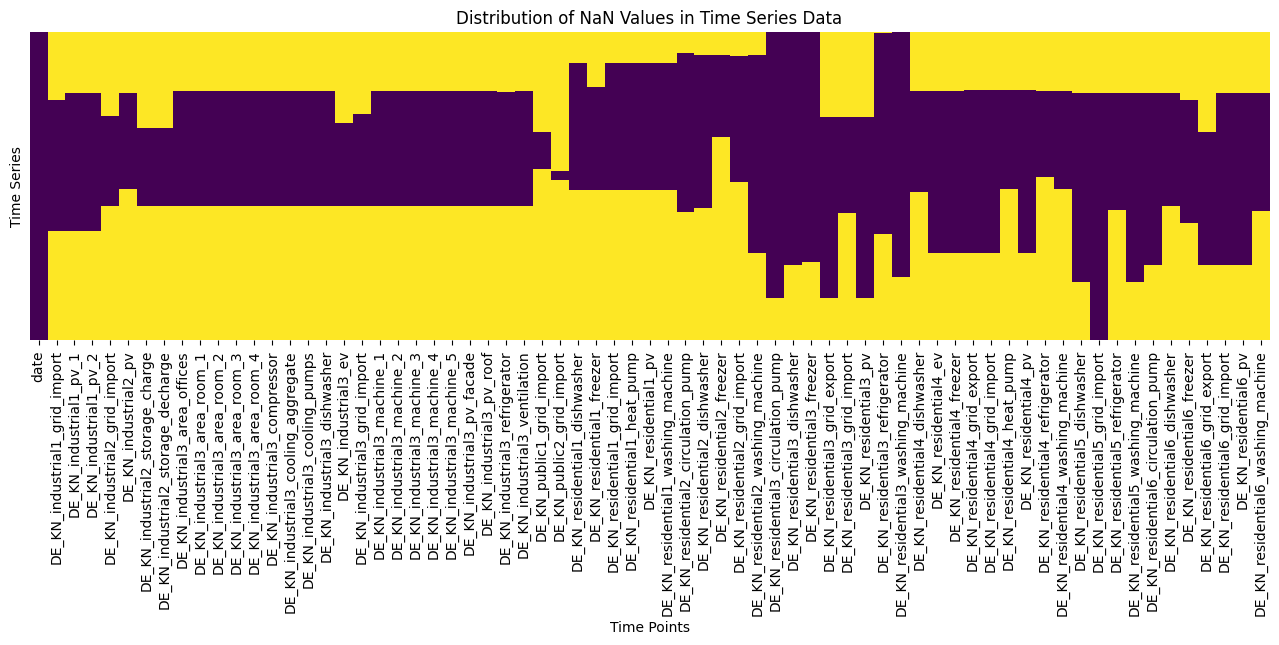

Columns dropped:  9


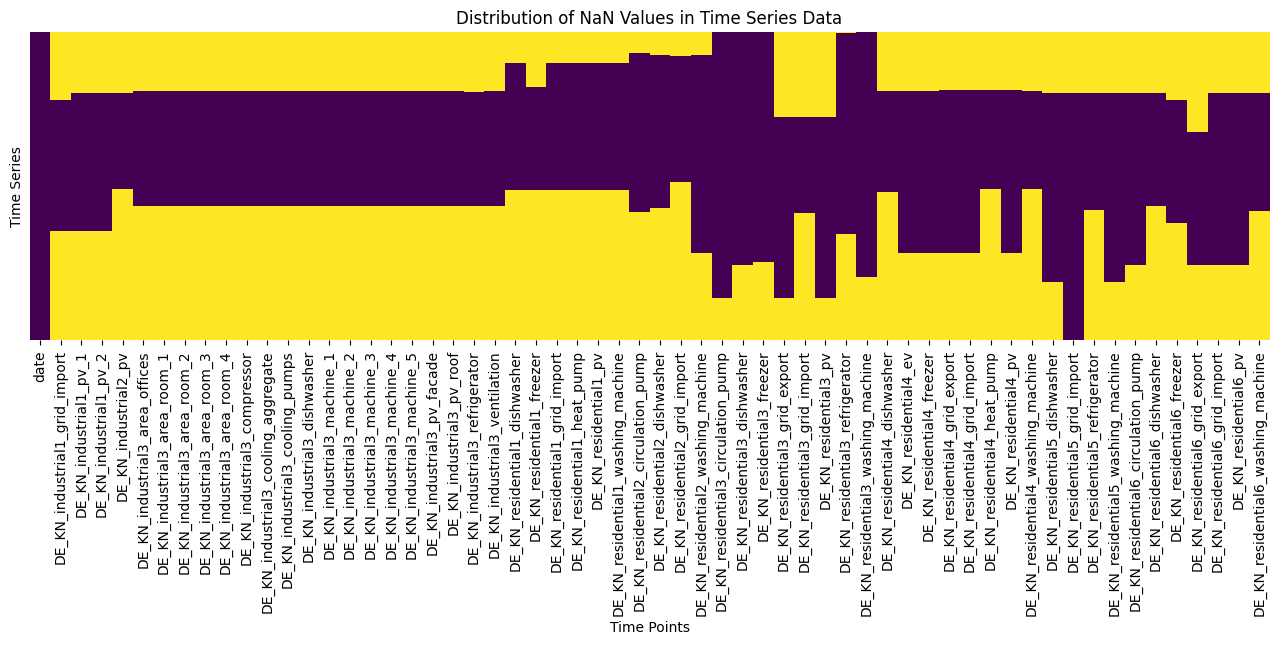

start rows removed:  7608
end rows removed:  16704


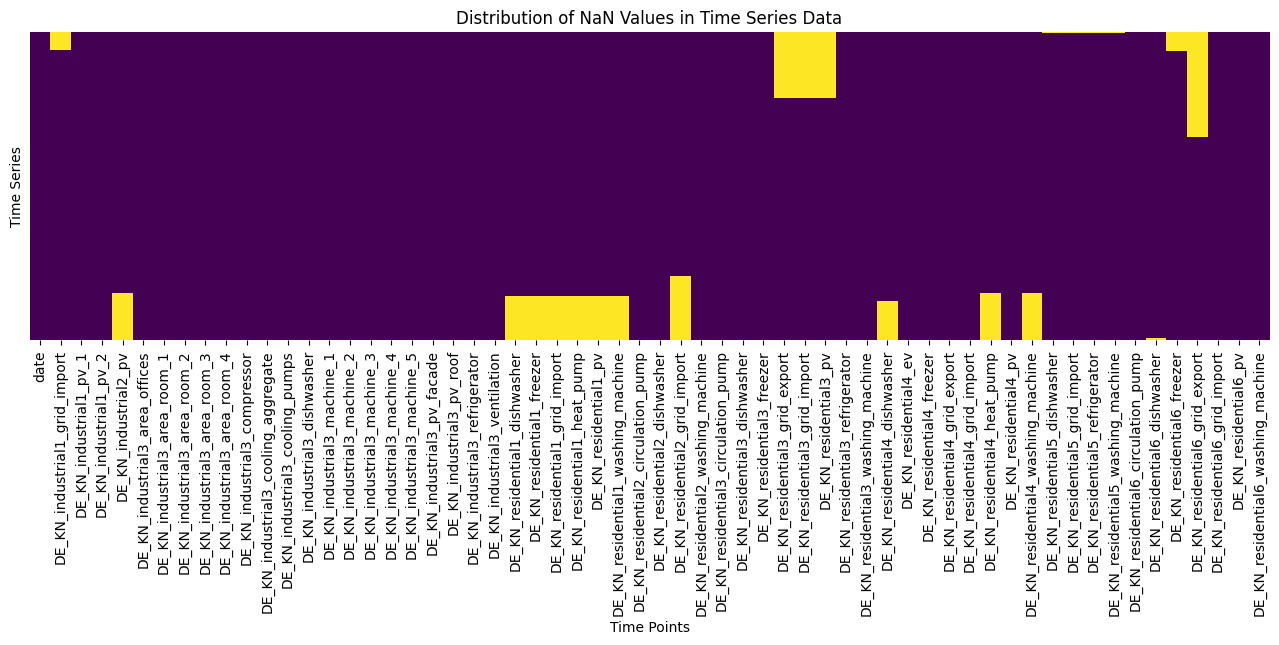

,date,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_pv,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,DE_KN_industrial3_area_room_3,DE_KN_industrial3_area_room_4,...,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
7608,2015-10-24 17:00:00+00:00,0.000,11.220,6.580,44.209,288.588,95.421,441.201,105.768,1005.448,...,0.000,0.000,0.000,0.056,0.000,0.000,0.00,2.390,0.00,0.000
7609,2015-10-24 18:00:00+00:00,0.000,11.220,6.580,44.209,289.291,95.591,442.562,105.788,1005.448,...,0.000,0.000,0.000,0.085,0.000,0.000,0.00,3.340,0.00,0.000
7610,2015-10-24 19:00:00+00:00,0.000,11.220,6.580,44.209,290.041,95.761,443.912,105.818,1005.448,...,0.000,0.000,0.000,0.114,0.000,0.000,0.00,3.770,0.00,0.000
7611,2015-10-24 20:00:00+00:00,0.000,11.220,6.580,44.209,290.791,95.931,445.292,105.838,1005.448,...,0.000,0.000,0.000,0.143,0.000,0.000,0.00,4.200,0.00,0.000
7612,2015-10-24 21:00:00+00:00,0.000,11.220,6.580,44.209,291.550,96.101,446.632,105.858,1005.448,...,0.000,0.000,0.000,0.172,0.000,0.000,0.00,4.615,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21745,2017-06-04 18:00:00+00:00,370529.789,7920.592,6148.334,22122.400,16045.196,5980.600,28675.514,5512.468,42743.021,...,4430.146,579.832,289.725,604.216,96.078,137.589,2277.77,5311.344,13503.87,75.325
21746,2017-06-04 19:00:00+00:00,370541.758,7920.592,6148.334,22122.400,16045.655,5980.761,28676.758,5512.478,42743.021,...,4430.261,579.888,289.725,604.243,96.078,137.592,2277.77,5311.344,13503.87,75.325
21747,2017-06-04 20:00:00+00:00,370556.539,7920.592,6148.334,22122.400,16046.106,5980.921,28677.998,5512.498,42743.021,...,4430.371,579.941,289.725,604.270,96.078,137.594,2277.78,5311.354,13503.87,75.325
21748,2017-06-04 21:00:00+00:00,370579.883,7920.592,6148.334,22122.400,16046.526,5981.086,28679.264,5512.528,42743.021,...,4430.461,579.974,289.725,604.298,96.078,137.597,2277.78,5311.354,13503.87,75.325


In [62]:
# bavaria dataset
from utils import data_handling
import random
import matplotlib.pyplot as plt
import config
import requests
import pandas as pd

#data_tensor = data_handling.load_bavaria_electricity()
#data_dict, standadizer = data_handling.train_test_split_eu_elec(data_tensor, standardize=True)


df = pd.read_csv(config.CONFIG_DATA["south_germany"] / "south_germany.csv")

# drop second timestamp column
df = df.drop('cet_cest_timestamp', axis=1)
df = df.drop('interpolated', axis=1)

# rename to fit DataSetClass
df.rename(columns={'utc_timestamp': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
visualize_nans(df)

# drop columns
threshold = 0.7 * len(df)
columns_to_drop = df.columns[df.isna().sum() > threshold]
df = df.drop(columns=columns_to_drop)
print("Columns dropped: ", len(columns_to_drop))
visualize_nans(df)

# drop rows at start and end with too many nan
counter_start = 0
while df.iloc[0].isnull().mean() > 0.20:
    df.drop(df.index[0], inplace=True)
    counter_start +=1
print("start rows removed: ", counter_start)

counter_end = 0
while df.iloc[-1].isnull().mean() > 0.20:
    df.drop(df.index[-1], inplace=True)
    counter_end += 1
print("end rows removed: ", counter_end)
visualize_nans(df)

# forward fill if previous values are present
df = df.fillna(method='ffill')
df = df.fillna(0)

# Sort the DataFrame based on the 'date' column
df = df.sort_values(by='date')
df

In [37]:
# bavaria dataset
data_tensor = data_handling.load_bavaria_electricity()
data_tensor.shape

torch.Size([12313, 67])

In [28]:
data_tensor = data_handling.load_bavaria_electricity()
data_tensor.shape

def train_test_split_bavaria(result_tensor, standardize=True):
    """
    -train test split for eu electricity dataset
    -returns dict with data
    -standardizes on train dataset values if True
    -returns dict with standardize metrics if True
    """
    train_cutoff = 0.7
    validation_cutoff = 0.8

    train_cutoff = int(round(train_cutoff * result_tensor.size(0)))
    validation_cutoff = int(round(validation_cutoff * result_tensor.size(0)))

    data_dict = {}
    data_dict["train"] = result_tensor[0:train_cutoff, :]
    data_dict["validation"] = result_tensor[train_cutoff : validation_cutoff, :]
    data_dict["test"] = result_tensor[validation_cutoff : , :]

    train_standardize_dict = None
    # normalize train and use matrics for val and test
    if standardize is True:
        data_dict["train"], train_standardize_dict = helpers.custom_standardizer(data_dict["train"])
        data_dict["validation"], _ = helpers.custom_standardizer(data_dict["validation"], train_standardize_dict)
        data_dict["test"], _ = helpers.custom_standardizer(data_dict["test"], train_standardize_dict)

    return data_dict, train_standardize_dict


eu_electricity, _ =  data_handling.train_test_split_eu_elec(data_tensor, standardize=True)


# Calculate the mean and standard deviation for each series (column)
means = data_tensor.mean(dim=0)
stds = data_tensor.std(dim=0)

# Normalize each series by subtracting the mean and dividing by the standard deviation
normalized_data = (data_tensor - means) / stds



tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])


In [ ]:
building_categories = {  "residential" : df.filter(regex='residential') , 
            "public" : df.filter(regex='public')  , 
            "industrial" : df.filter(regex='industrial')  
        }

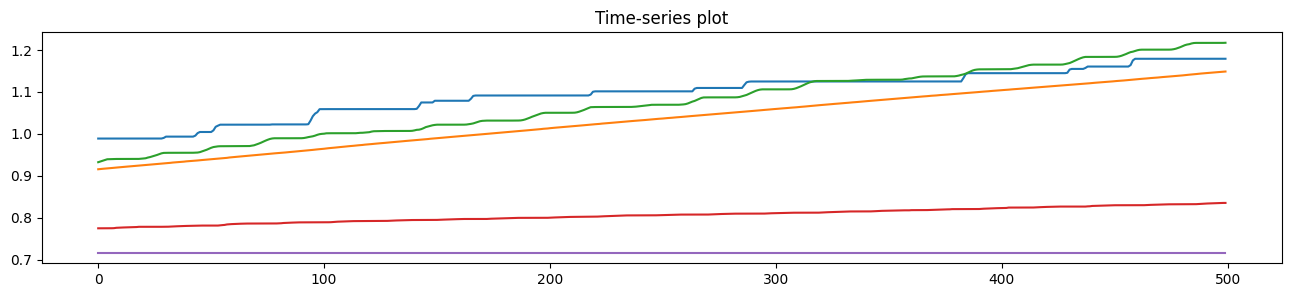

In [ ]:
train_tensor = data_dict["electricity_train"]

time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)

numpy_array = train_tensor[time_id : time_id+500 , ids : ids+10].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

In [3]:
def visualize_nans(df):
	# Create a heatmap to visualize the distribution of NaN values after removing some
	nan_counts = df.isna().sum()

	plt.figure(figsize=(16, 4))
	sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
	plt.xlabel('Time Points')
	plt.ylabel('Time Series')
	plt.title('Distribution of NaN Values in Time Series Data')
	plt.show()

path = "/home/ben_ten/ben/MA/datasets/household_south_germany_hourly/household_data_60min_singleindex.csv"
df = pd.read_csv(path)

# drop second timestamp column
df = df.drop('cet_cest_timestamp', axis=1)
df = df.drop('interpolated', axis=1)

# rename to fit DataSetClass
df.rename(columns={'utc_timestamp': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])



# drop columns with more than 90% missing values
threshold = 0.9 * len(df)
columns_to_drop = df.columns[df.isna().sum() > threshold]
df = df.drop(columns=columns_to_drop)
visualize_nans(df)

# drop rows with more than 10% NANs
threshold = 0.20 * len(df.columns)
df = df[df.isna().sum(axis=1) <= threshold]
visualize_nans(df)

# forward fill if previous values are present
df = df.fillna(method='ffill')

# values at the start are set to zero, no more NANs
df = df.fillna(0)

visualize_nans(df)

df

FileNotFoundError: [Errno 2] No such file or directory: '/home/ben_ten/ben/MA/datasets/household_south_germany_hourly/household_data_60min_singleindex.csv'

In [40]:
# Sort the DataFrame based on the 'date' column
df = df.sort_values(by='date')
df = df.drop(columns=['date'])

# Define the split sizes - these values can be changed according to your needs
train_size = 0.7
val_size = 0.10
test_size = 0.20

# Calculate the indices for the split
train_index = int(len(df) * train_size)
val_index = train_index + int(len(df) * val_size)

# Split the DataFrame
train = df[:train_index]
val = df[train_index:val_index]
test = df[val_index:]

# Convert the DataFrames to 2D arrays
train_array = train.values
val_array = val.values
test_array = test.values

# Convert the arrays to tensors
train_tensor = torch.tensor(train_array, dtype=torch.float32)
val_tensor = torch.tensor(val_array, dtype=torch.float32)
test_tensor = torch.tensor(test_array, dtype=torch.float32)

In [43]:
# Convert the arrays to tensors
train_tensor = torch.tensor(train_array, dtype=torch.float32)
val_tensor = torch.tensor(val_array, dtype=torch.float32)
test_tensor = torch.tensor(test_array, dtype=torch.float32)

# Now you have your tensors
# Check if they have the correct shape: (time_series x id)
print(train_tensor.shape)
print(val_tensor.shape)
print(test_tensor.shape)

torch.Size([8619, 67])
torch.Size([1231, 67])
torch.Size([2463, 67])


# Building genome project 


outliers:
 A log conversion and pruning technique were used with any high outliers greater than three standard deviations from the mean on the log-transformed data converted to NaN values. Finally, all meter data was rounded to four decimal places.

In [4]:
data_tensor = data_handling.load_genome_project_data()
data_tensor.shape

torch.Size([14621, 1455])

In [ ]:
gp_dict, standadizer = data_handling.train_test_split_eu_elec(data_tensor, standardize=True)

In [40]:
url = "https://github.com/buds-lab/building-data-genome-project-2/raw/master/data/meters/cleaned/electricity_cleaned.csv?download="
url_kaggle_dataset = "https://github.com/buds-lab/building-data-genome-project-2/raw/master/data/meters/kaggle/kaggle.csv?download="

filename = config.CONFIG_DATA["genome_project"] / "genome_project_dataset.csv"
filename_kaggle = config.CONFIG_DATA["genome_project"] / "genome_project_dataset_kaggle.csv"

# URL of the raw CSV file on GitHub
url = url_kaggle_dataset
filename = filename_kaggle


# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Write the content of the response to a local file
    with open(filename, 'wb') as file:
        file.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to retrieve the CSV file. Status code:", response.status_code)

CSV file downloaded successfully.


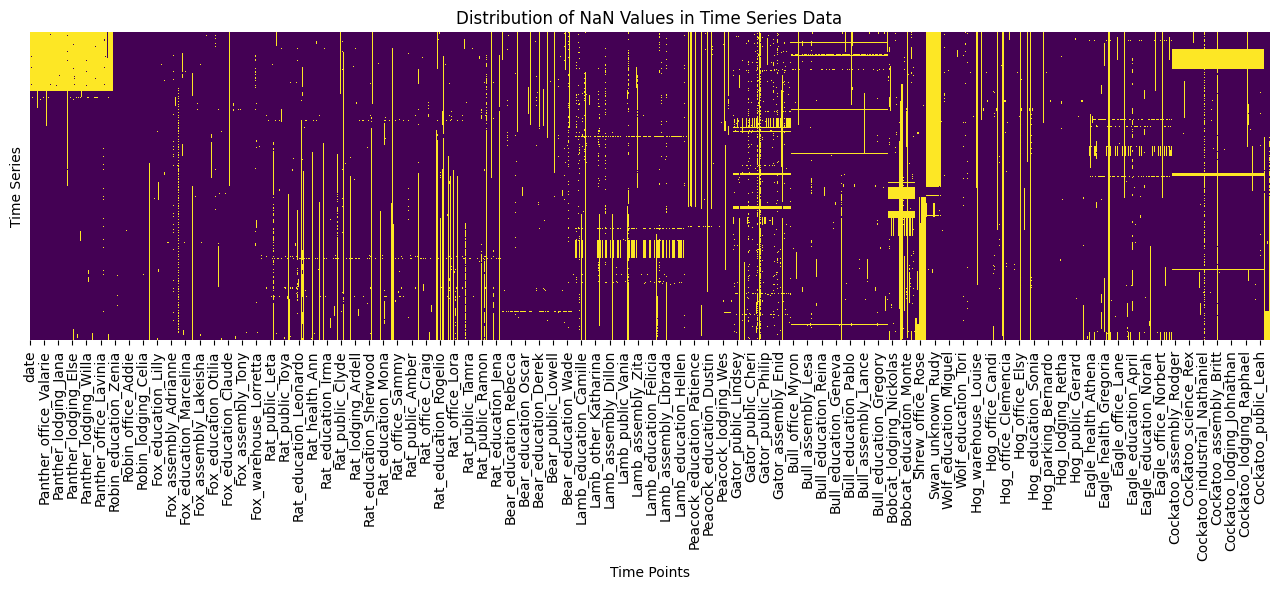

columns dropped:  123


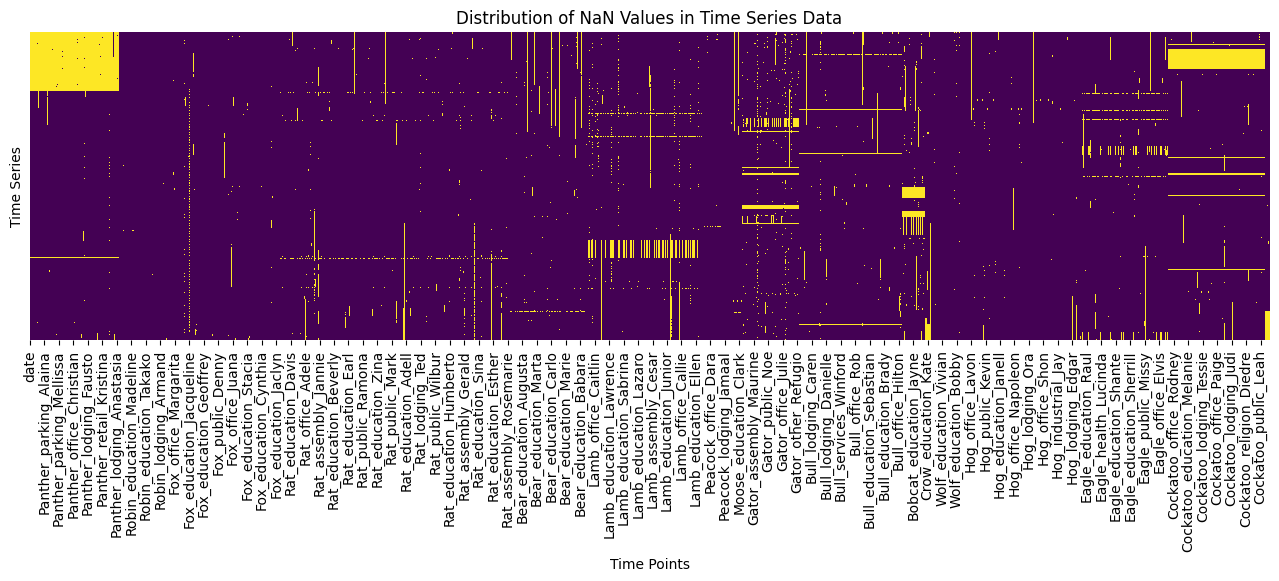

start rows removed:  2923
end rows removed:  0


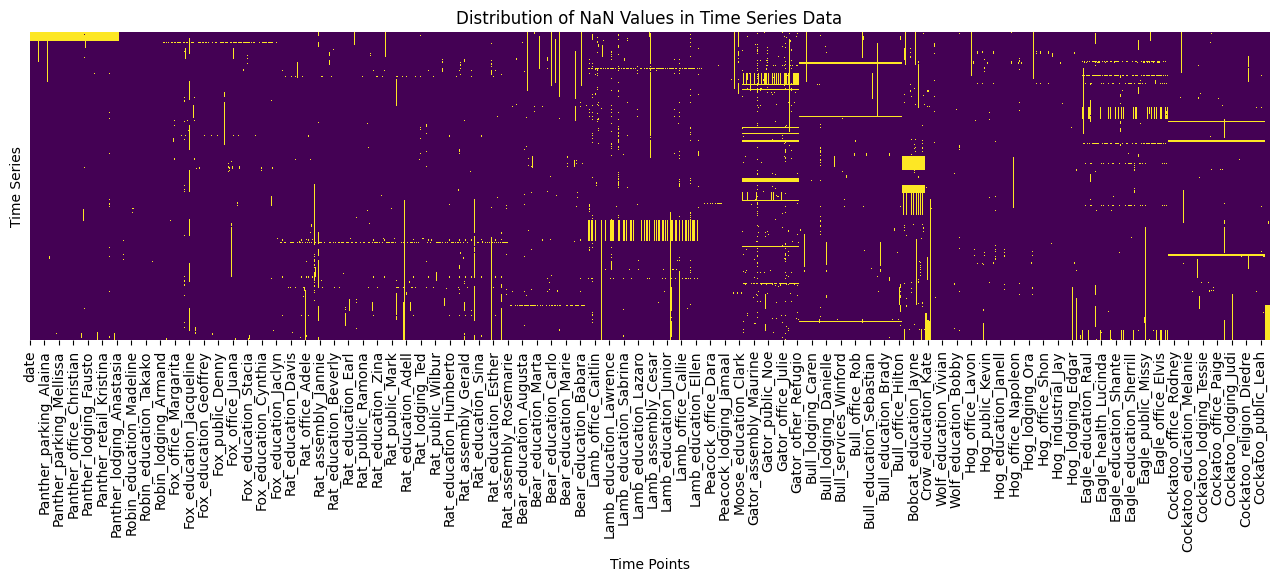

In [2]:
filename = config.CONFIG_DATA["genome_project"] / "genome_project_dataset.csv"

df = pd.read_csv(filename)
# rename to fit DataSetClass
df.rename(columns={'timestamp': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

visualize_nans(df)
# drop columns with more than 40% missing values
threshold = 0.40 * len(df)
columns_to_drop = df.columns[df.isna().sum() > threshold]
df = df.drop(columns=columns_to_drop)
print("columns dropped: ", len(columns_to_drop))
visualize_nans(df)

# drop rows with more than 5% NANs from start and end
counter_start = 0
while df.iloc[0].isnull().mean() > 0.05:
    df.drop(df.index[0], inplace=True)
    counter_start +=1
print("start rows removed: ", counter_start)

counter_end = 0
while df.iloc[-1].isnull().mean() > 0.05:
    df.drop(df.index[-1], inplace=True)
    counter_end += 1
print("end rows removed: ", counter_end)
visualize_nans(df)


# forward fill if previous values are present
df = df.fillna(method='ffill')
df = df.fillna(0)




In [3]:
df_temp = df

In [4]:
df_temp.describe()

,date,Panther_parking_Lorriane,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_education_Misty,...,Cockatoo_education_Amira,Cockatoo_public_Harland,Cockatoo_public_Caleb,Cockatoo_education_Tyler,Cockatoo_public_Shad,Mouse_health_Modesto,Mouse_lodging_Vicente,Mouse_health_Justin,Mouse_health_Ileana,Mouse_health_Estela
count,14621,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,...,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000
mean,2017-03-02 09:00:00,11.181520,132.042026,6.950172,145.495071,161.108165,503.031275,123.590348,27.766013,32.897027,...,48.583485,50.510979,179.107407,767.211893,127.882874,442.856304,44.583476,797.768062,39.607790,375.490015
min,2016-05-01 19:00:00,3.720700,14.002700,1.123200,37.607300,4.666900,84.016200,7.536500,4.100800,3.600700,...,2.875000,20.175000,83.350000,548.800000,60.050000,93.482000,10.000000,0.001700,7.000000,2.000000
25%,2016-10-01 02:00:00,8.701700,118.222800,3.741700,122.263600,122.079500,462.989300,81.206700,16.903300,26.885200,...,37.550000,42.075000,131.075000,731.125000,95.825000,297.951000,30.000000,685.731000,27.000000,308.000000
50%,2017-03-02 09:00:00,10.862100,132.225500,6.104200,146.988400,155.605000,477.592200,117.448700,34.006600,37.447200,...,42.050000,48.275000,169.225000,759.950000,124.575000,388.782000,40.000000,755.828000,32.000000,332.000000
75%,2017-08-01 16:00:00,12.962500,148.878700,9.188800,162.991500,190.380700,518.900100,161.524200,36.006900,39.367600,...,56.550000,59.950000,226.625000,801.350000,156.850000,520.425000,60.000000,900.799000,51.387800,441.000000
max,2017-12-31 23:00:00,25.497200,285.451200,27.770400,298.053200,375.038400,1052.711000,279.125900,54.804300,74.733100,...,108.075000,83.600000,309.250000,925.550000,278.575000,1265.029000,100.000000,1487.017000,101.000000,665.000000
std,NaN,3.733719,29.448785,3.910295,40.185954,48.021884,106.974612,51.043272,10.399592,9.179778,...,15.048207,11.652970,53.955308,47.720311,36.805464,177.528247,14.514651,172.980543,17.764031,94.891911


In [5]:
# building genome project dataset
data_tensor = data_handling.load_genome_project_data()
gp_dict, standadizer = data_handling.train_test_split_eu_elec(data_tensor, standardize=True)

In [14]:
tensor = gp_dict["train"][:,0]

array = tensor.numpy()

x = torch.arange(0, 10235).numpy()


x.shape

(10235,)

In [36]:
import torch
train = gp_dict["train"]
test = gp_dict["test"]
val = gp_dict["validation"]

data = torch.cat([train, test, val])

# Compute mean and standard deviation
mean = torch.mean(data, dim=0)
std_dev = torch.std(data, dim=0)

# Calculate Z-scores
z_scores = (data - mean) / std_dev

# Define a threshold for finding outliers
threshold = 3

# Identify outliers
outliers = torch.abs(z_scores) > threshold
print("Outlier indices:\n", outliers)


Outlier indices:
 tensor([[ True,  True, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


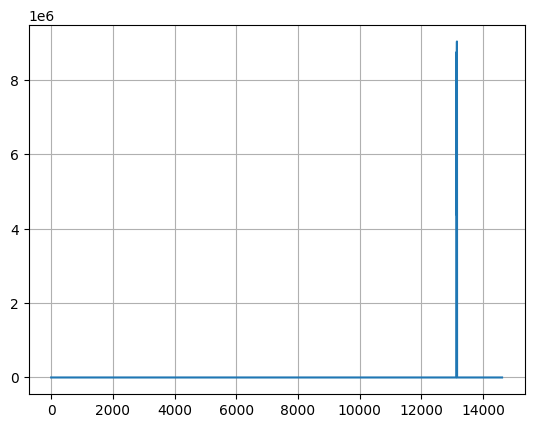

In [41]:
visualize_id(707)

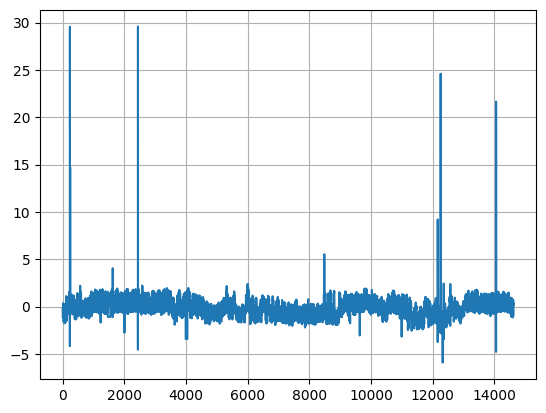

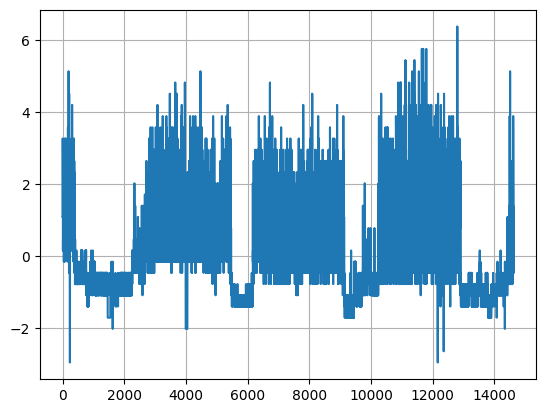

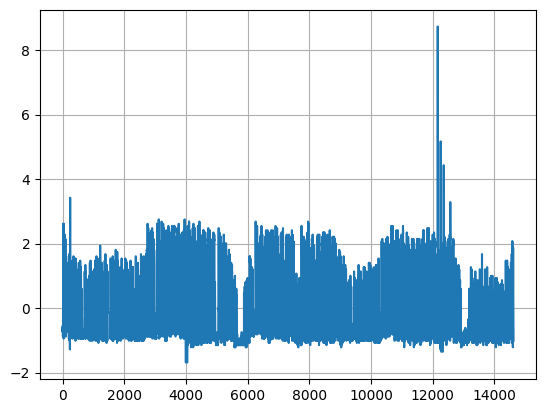

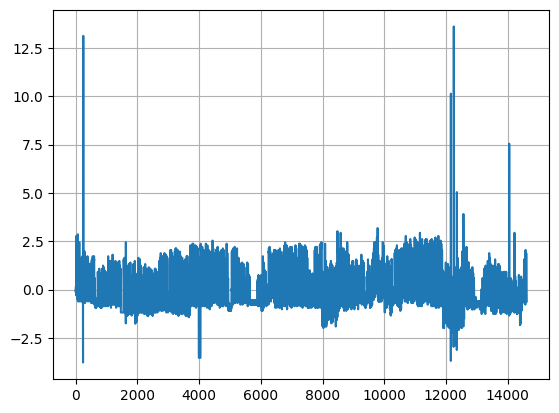

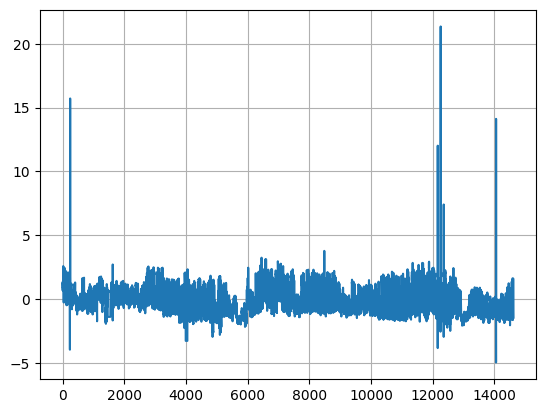

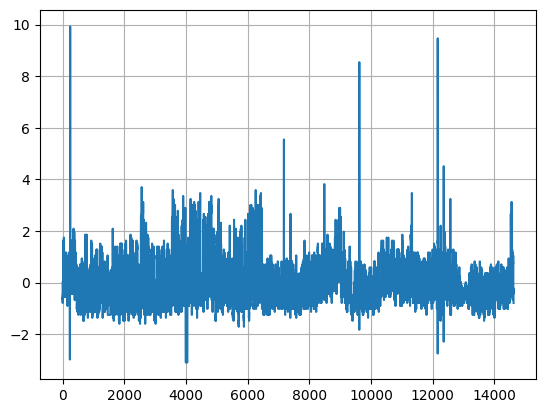

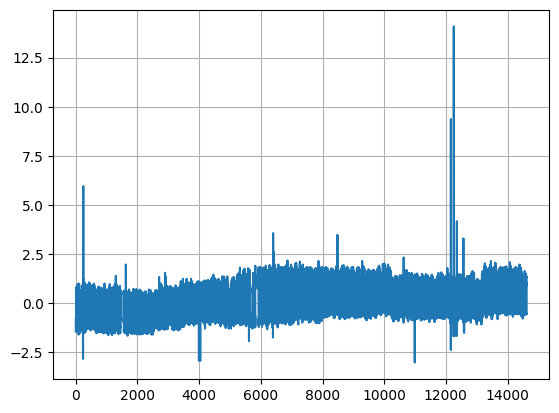

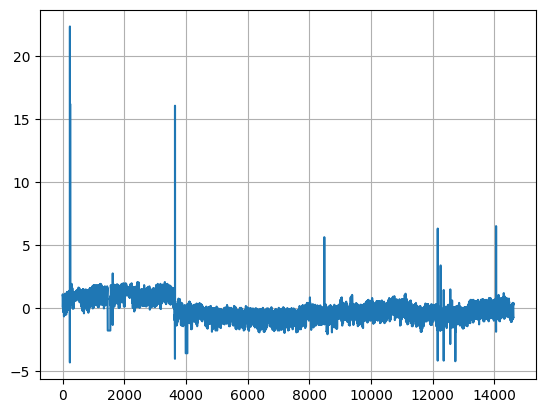

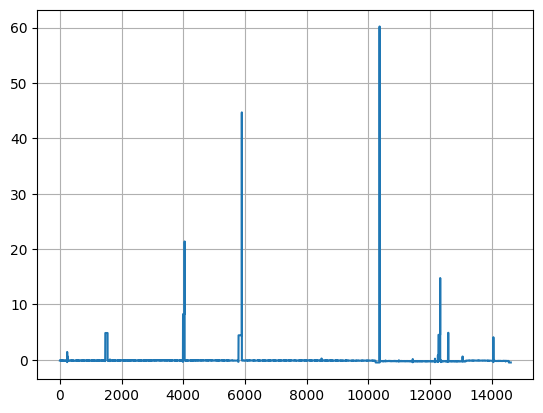

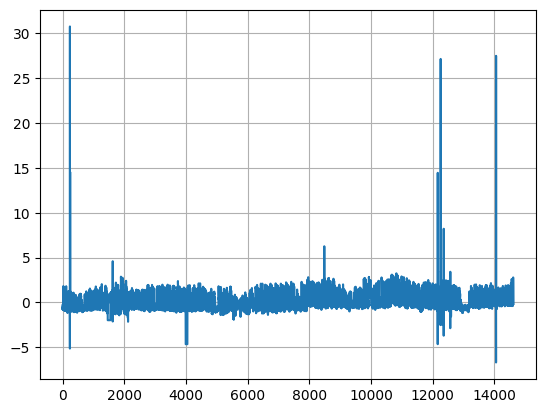

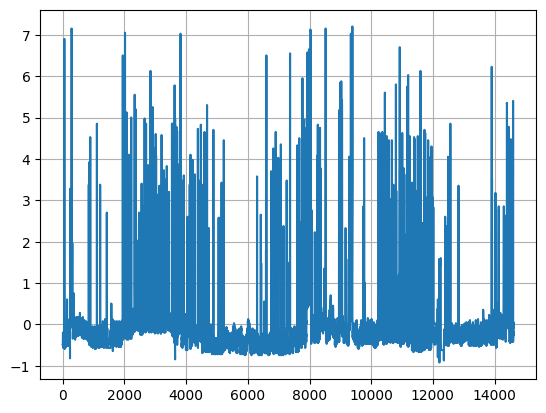

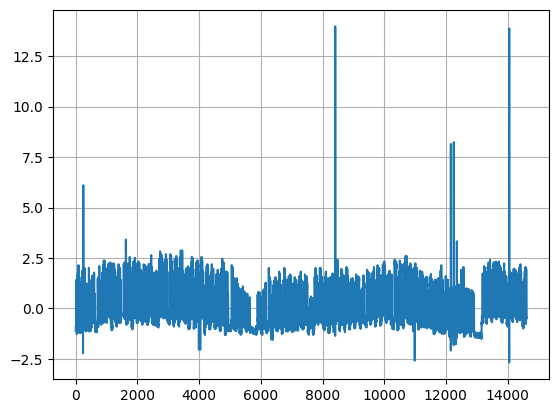

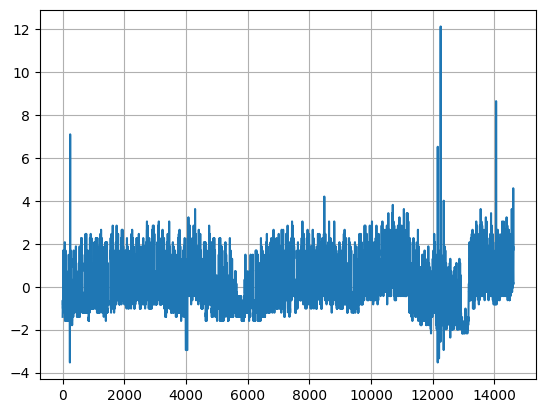

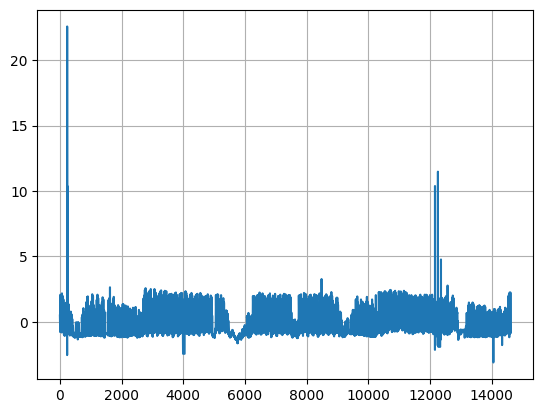

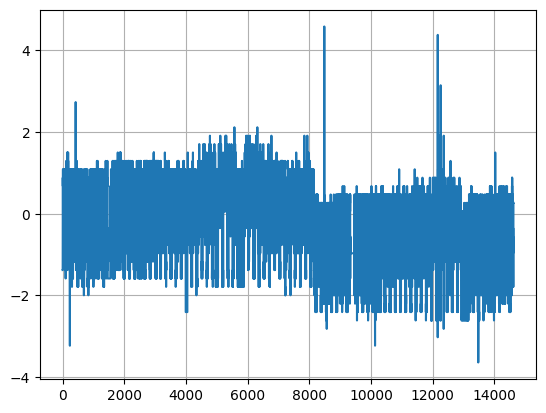

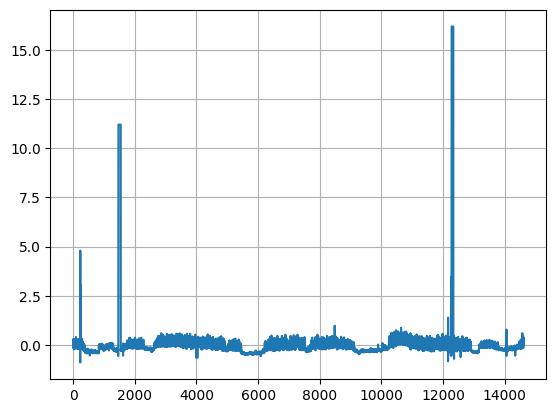

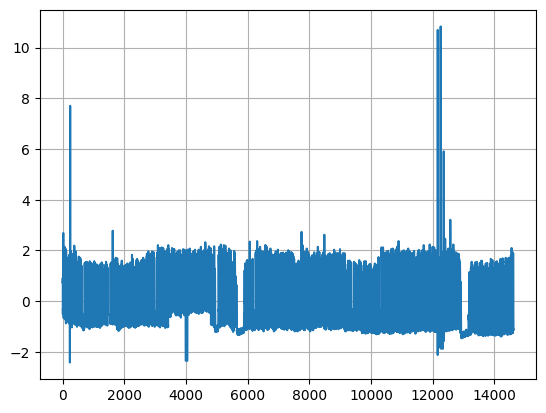

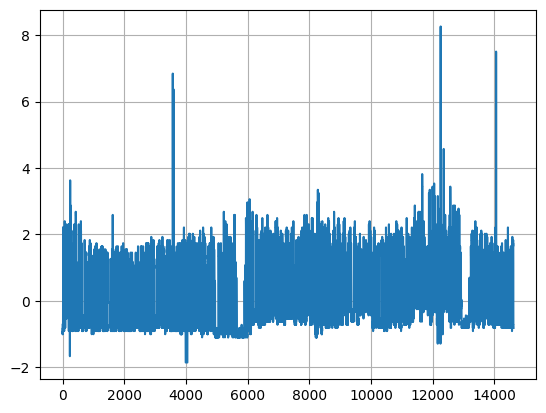

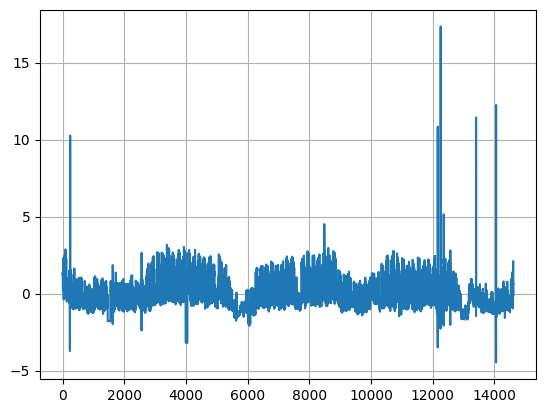

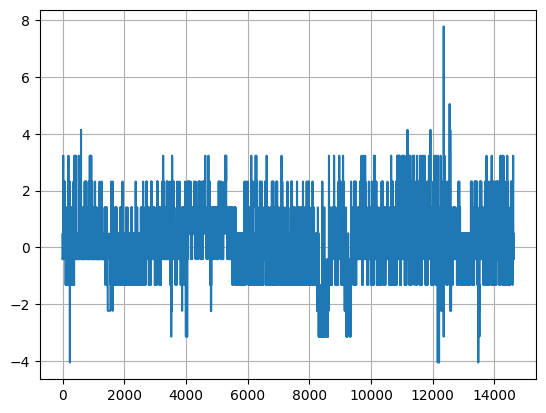

In [32]:
def visualize_id(id):

    train = gp_dict["train"][:,id]
    test = gp_dict["test"][:,id]
    val = gp_dict["validation"][:,id]

    array = torch.cat([train, test, val])
    array = array.numpy()

    # Create a histogram
    plt.plot(array)#, x = x )
    plt.grid(True)
    plt.show()

for i in range(1000,1020):
    visualize_id(i)
